# Preprocessing of High-Density EEG Recordings

# 0. Load parameters

In [1]:
subject = "101"

In [2]:
# Injected Parameters
subject = 101


In [3]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_lof
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels, plot_epochs
from spectral.specparam import specparam2pandas

import numpy as np

from spectral.ica import (
    compute_ica,
    label_components_ica,
    plot_ica_components,
    plot_removed_components,
)

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]
specparam_path = my_paths["specparam_path"]
Path(specparam_path).mkdir(parents=True, exist_ok=True)


print_date_time()

Using matplotlib as 2D backend.
/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/
2024-04-30 02:07:25


This file contains preprocessing files after downsampling them.

# 1. Preprocess raw data

In [4]:
fline = 50
h_freq = 40
notch_freq = 50

filter_params = {
    "l_freq": 1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
    "picks": ["ecg", "eeg"],
}

raw = load_data(subject, project_path=project_path).resample(250)
try:
    raw_filtered = (
        raw.copy()
        .crop(tmin=0, tmax=300, include_tmax=True)
        .filter(**filter_params)
        .notch_filter(freqs=[notch_freq], phase="zero", method="iir")
    )
except Exception as e:
    print(f"An error occurred: {e}")
    raw_filtered = (
        raw.copy()
        .filter(**filter_params)
        .notch_filter(freqs=[notch_freq], phase="zero", method="iir")
    )
bad_channels = [
    "E67",
    "E73",
    "E82",
    "E91",
    "E92",
    "E102",
    "E111",
    "E120",
    "E133",
    "E145",
    "E165",
    "E174",
    "E187",
    "E199",
    "E208",
    "E209",
    "E216",
    "E217",
    "E218",
    "E219",
    "E225",
    "E226",
    "E227",
    "E228",
    "E229",
    "E230",
    "E231",
    "E232",
    "E233",
    "E234",
    "E235",
    "E236",
    "E237",
    "E238",
    "E239",
    "E240",
    "E241",
    "E242",
    "E243",
    "E244",
    "E245",
    "E246",
    "E247",
    "E248",
    "E249",
    "E250",
    "E251",
    "E252",
    "E253",
    "E254",
    "E255",
    "E256",
]
raw_filtered.info["bads"] = bad_channels

Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB



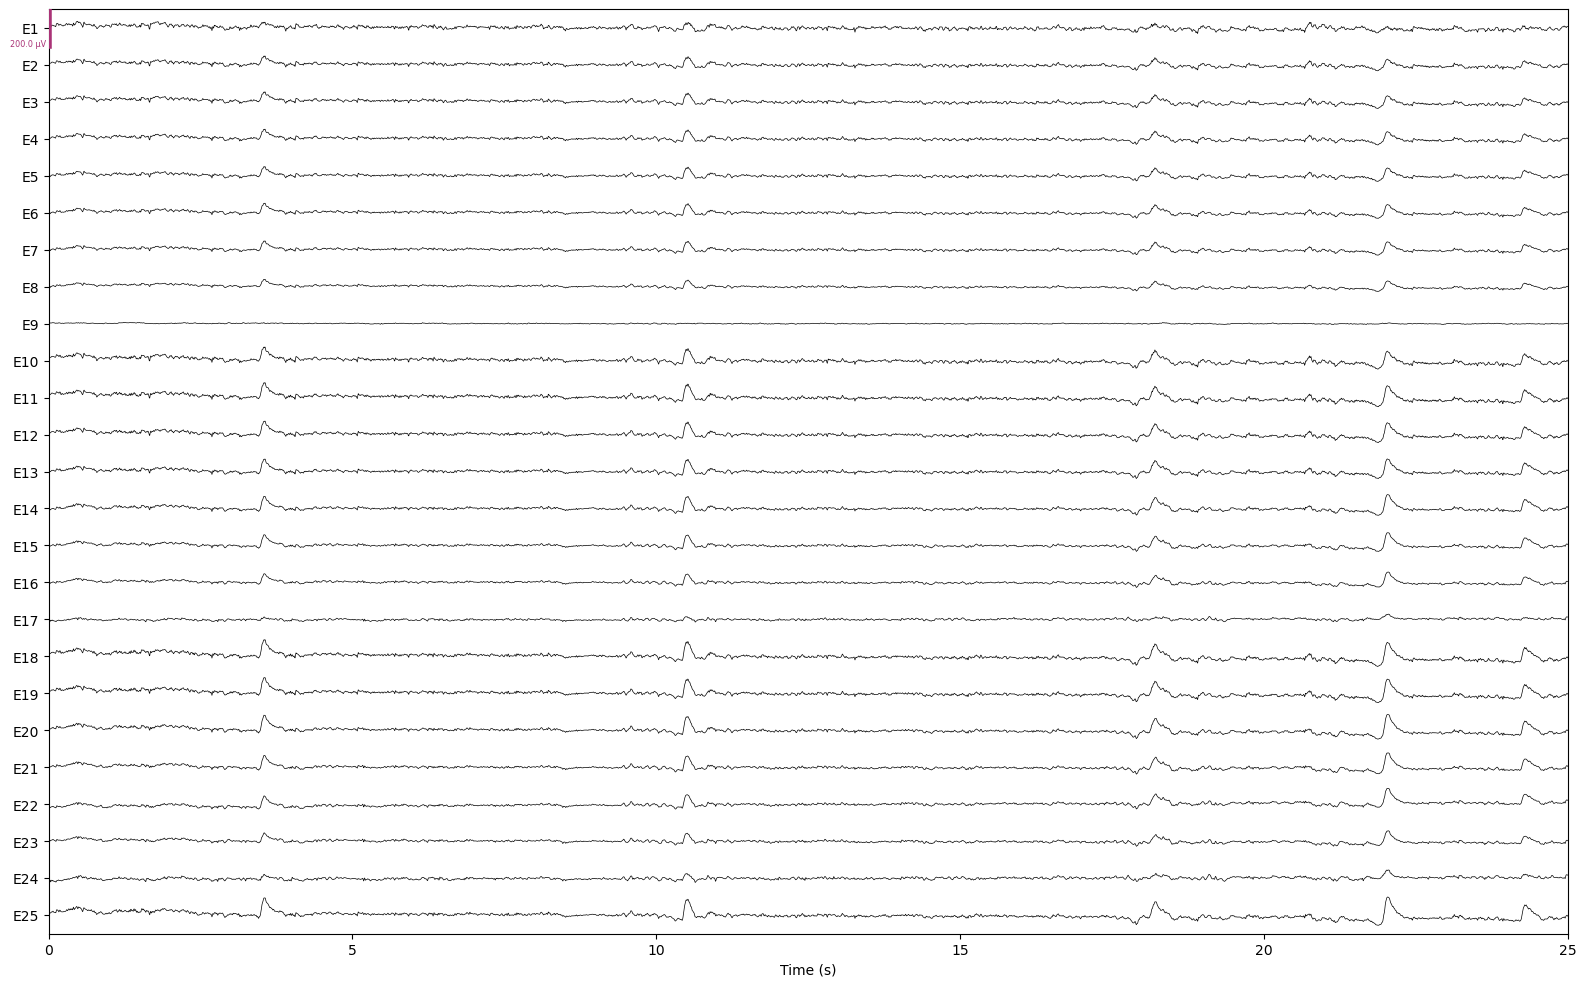

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


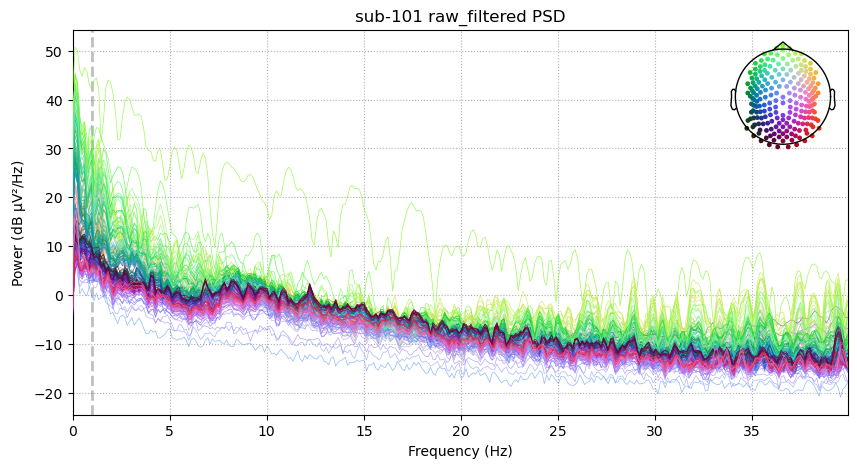

In [5]:
plot_step(
    raw_filtered,
    subject,
    figures_path,
    stage="raw_filtered",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

In [6]:
pyprep = True

if pyprep:
    bad_channels_by_ransac = apply_pyprep(raw_filtered, output="dict", as_dict=True)
else:
    bad_channels_by_ransac = get_bad_channels(raw_filtered)

raw_pyprep = raw_filtered.copy()
raw_pyprep.info["bads"].extend(bad_channels_by_ransac["bad_all"])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 202
Total # of chunks: 1
Current chunk:
1

RANSAC done!


In [7]:
print(bad_channels_by_ransac)

{'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['E9', 'E132'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['E132', 'E9']}


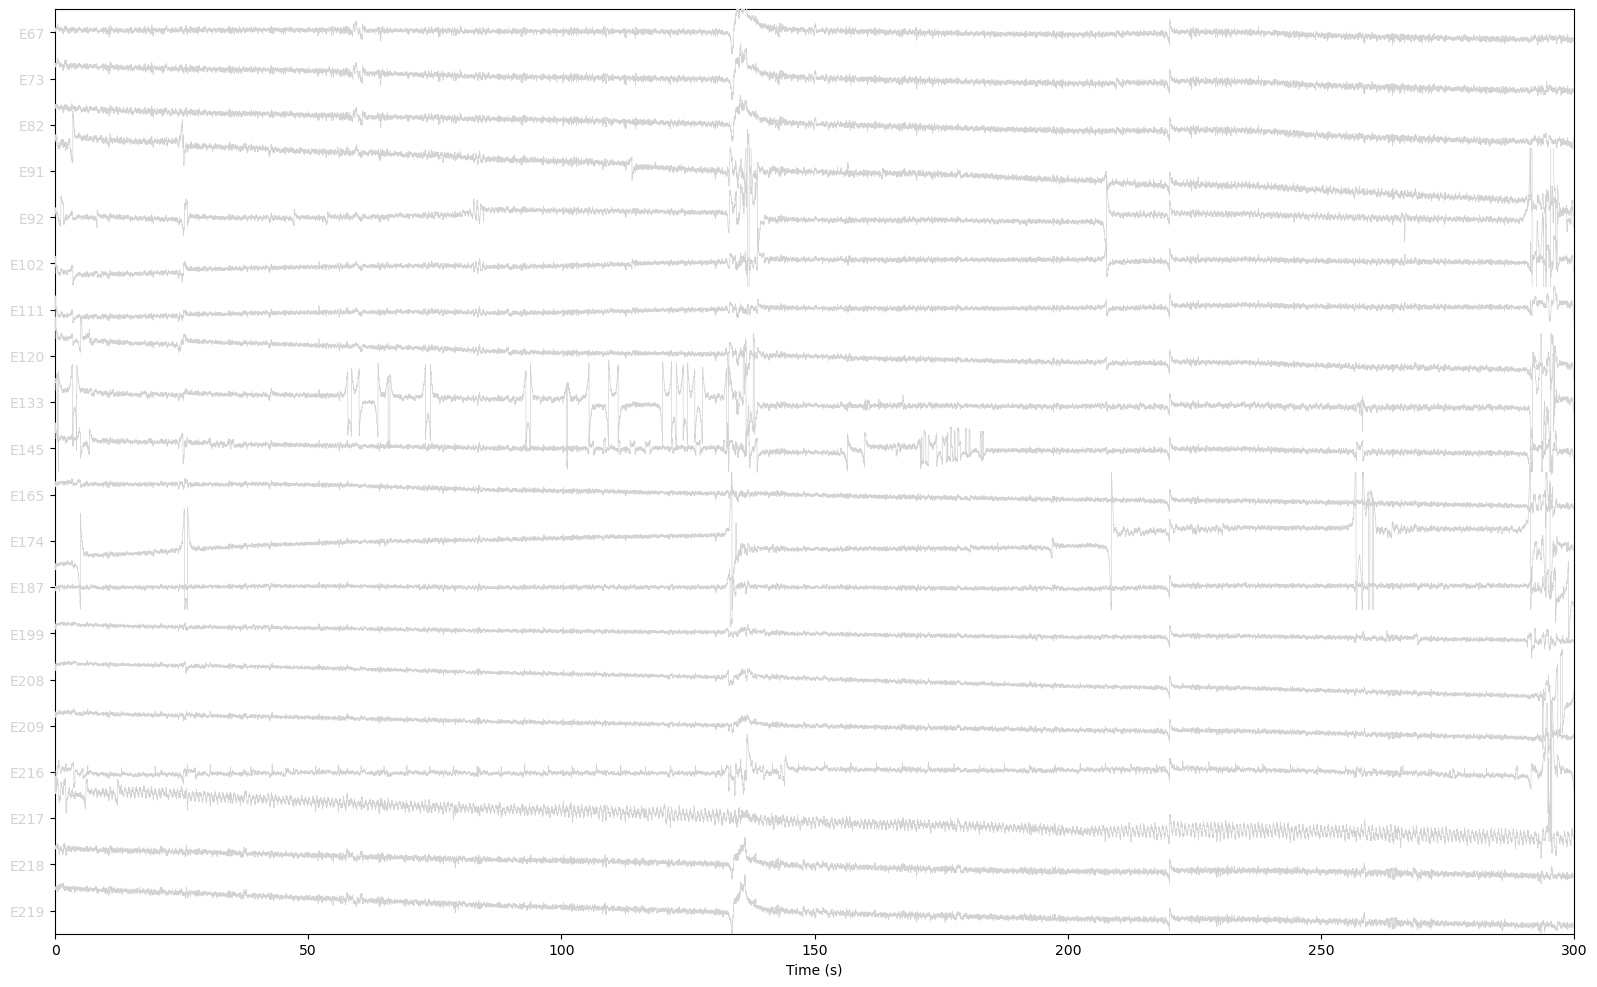

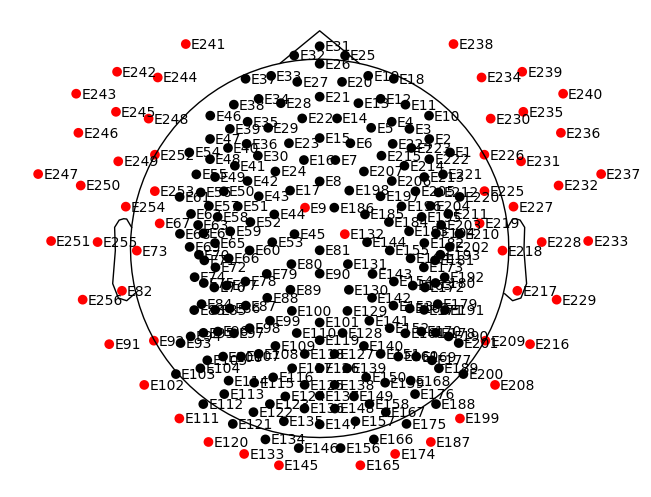

Overwriting existing file.
Writing /Users/daniel/PhD/Projects/psd-path/analysis/sub-101_filtered_raw.fif
Closing /Users/daniel/PhD/Projects/psd-path/analysis/sub-101_filtered_raw.fif
[done]


In [8]:
_ = plot_bad_channels(raw_pyprep, subject, figures_path=figures_path)
raw_pyprep.save(
    f"{project_path}/analysis/sub-{subject}_filtered_raw.fif", overwrite=True
)

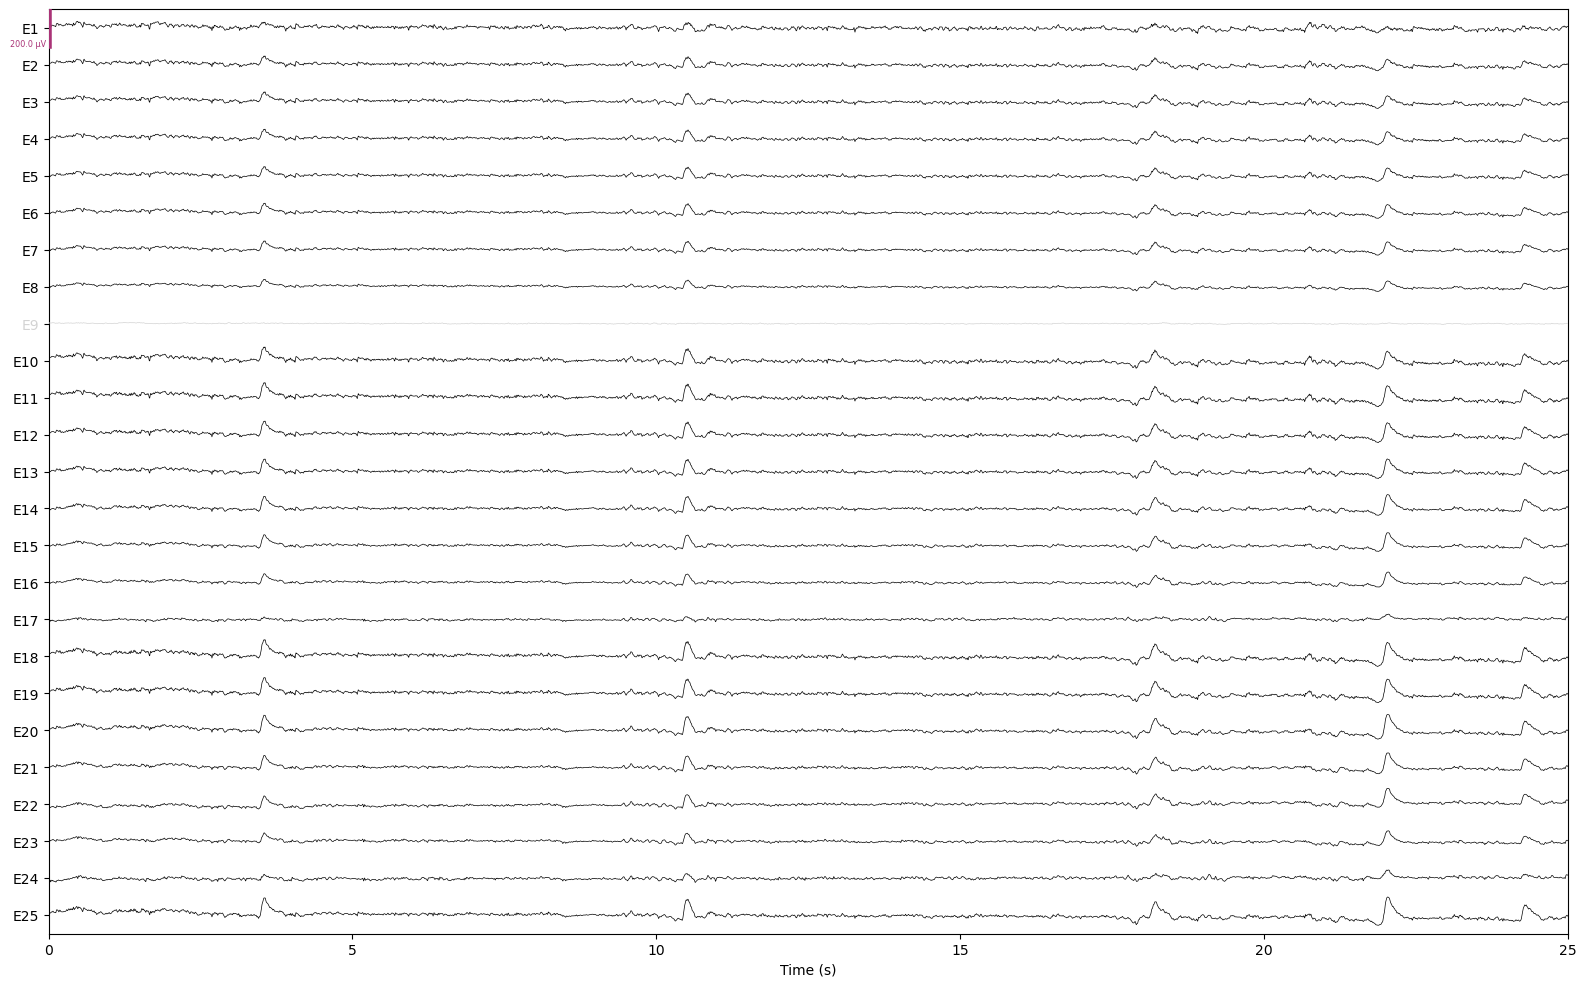

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/Users/daniel/.pyenv/versions/conda-paths-3.12/lib/python3.12/site-packages/spectral/viz.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


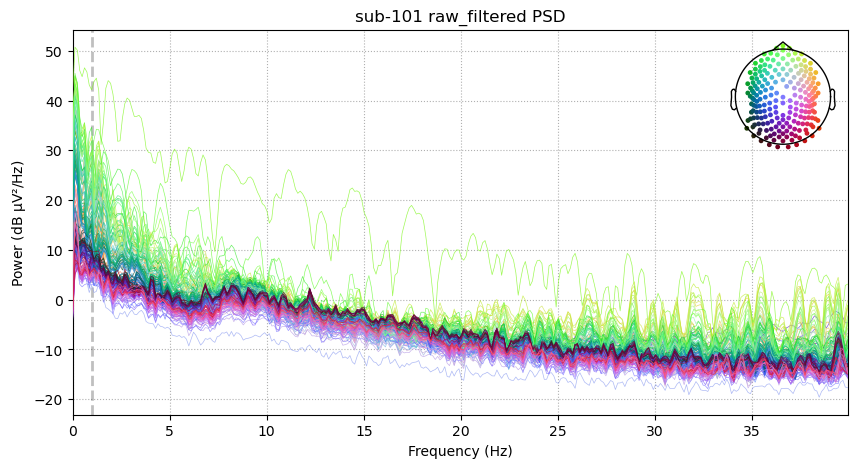

In [9]:
plot_step(
    raw_pyprep,
    subject,
    figures_path,
    stage="raw_filtered",
    duration=25.0,
    n_channels=25,
    fmax=h_freq,
)

Not setting metadata
85 matching events found
No baseline correction applied


0 projection items activated
Using data from preloaded Raw for 85 events and 1251 original time points ...
0 bad epochs dropped
fitting finished
Dropped 7 epochs: 16, 37, 38, 39, 62, 83, 84


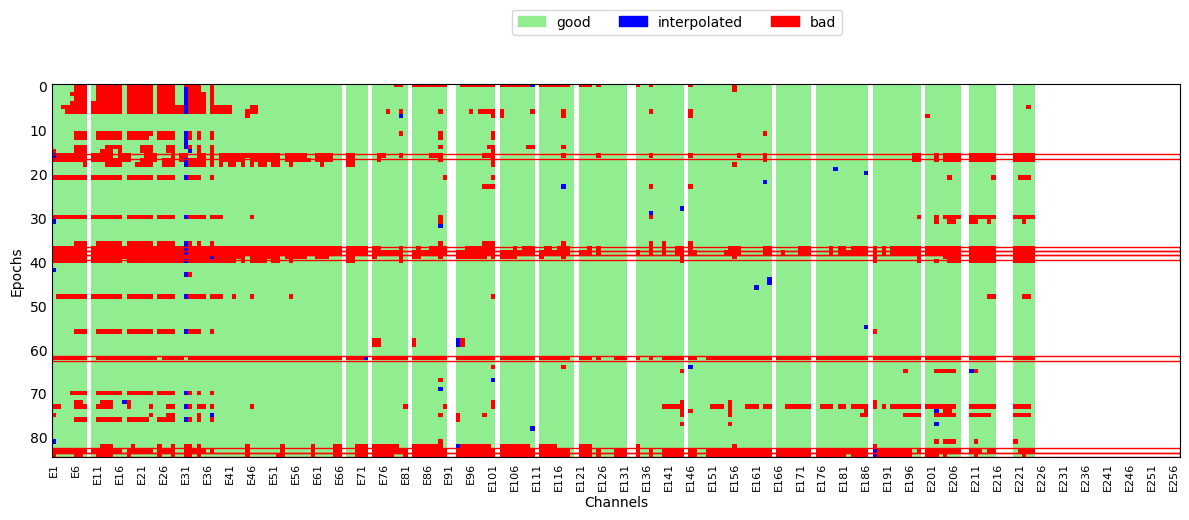

Additional 0 bad channels found:[]
An error occurred: No appropriate channels found for the given picks ([])


In [10]:
from spectral.epochs import create_epochs, get_reject_log

# raw_annotated = raw_pyprep.copy()
epochs = create_epochs(raw_pyprep, overlap=1.5)

reject_log = get_reject_log(
    epochs, resample=50, n_interpolate=[1], consensus=[0.40])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.40

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)

# epochs.info["bads"].extend(bad_channels_by_epochs)
try:
    bad_channel_plot_additional = epochs.plot(
        picks=bad_channels_by_epochs,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")

Effective window size : 5.004 (s)
Plotting power spectral density (dB=True).
Averaging across epochs...
Effective window size : 5.004 (s)
Plotting power spectral density (dB=True).
Averaging across epochs...


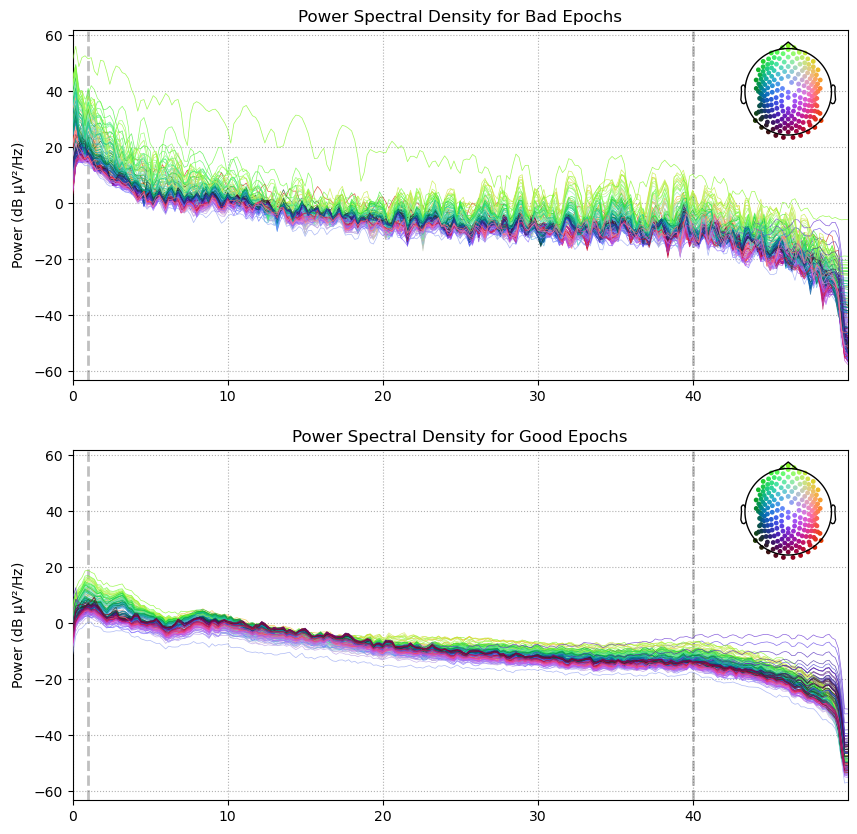

In [11]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

epochs_plot_psd = epochs[reject_log.bad_epochs].compute_psd(
    method="welch", picks="eeg", fmax=50., exclude="bads"
).plot(average=False, picks="eeg", exclude="bads", show=False, amplitude=False,  axes=axs[0])
axs[0].set_title('Power Spectral Density for Bad Epochs')

epochs_plot_psd = epochs[~reject_log.bad_epochs].compute_psd(
    method="welch", picks="eeg", fmax=50., exclude="bads"
).plot(average=False, picks="eeg", exclude="bads", show=False, amplitude=False,  axes=axs[1])

axs[1].set_title('Power Spectral Density for Good Epochs')


# Get the y-limits of both plots
ylim1 = axs[0].get_ylim()
ylim2 = axs[1].get_ylim()

# Set the same limits on the y-axis for both plots
axs[0].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
axs[1].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))


plt.show()

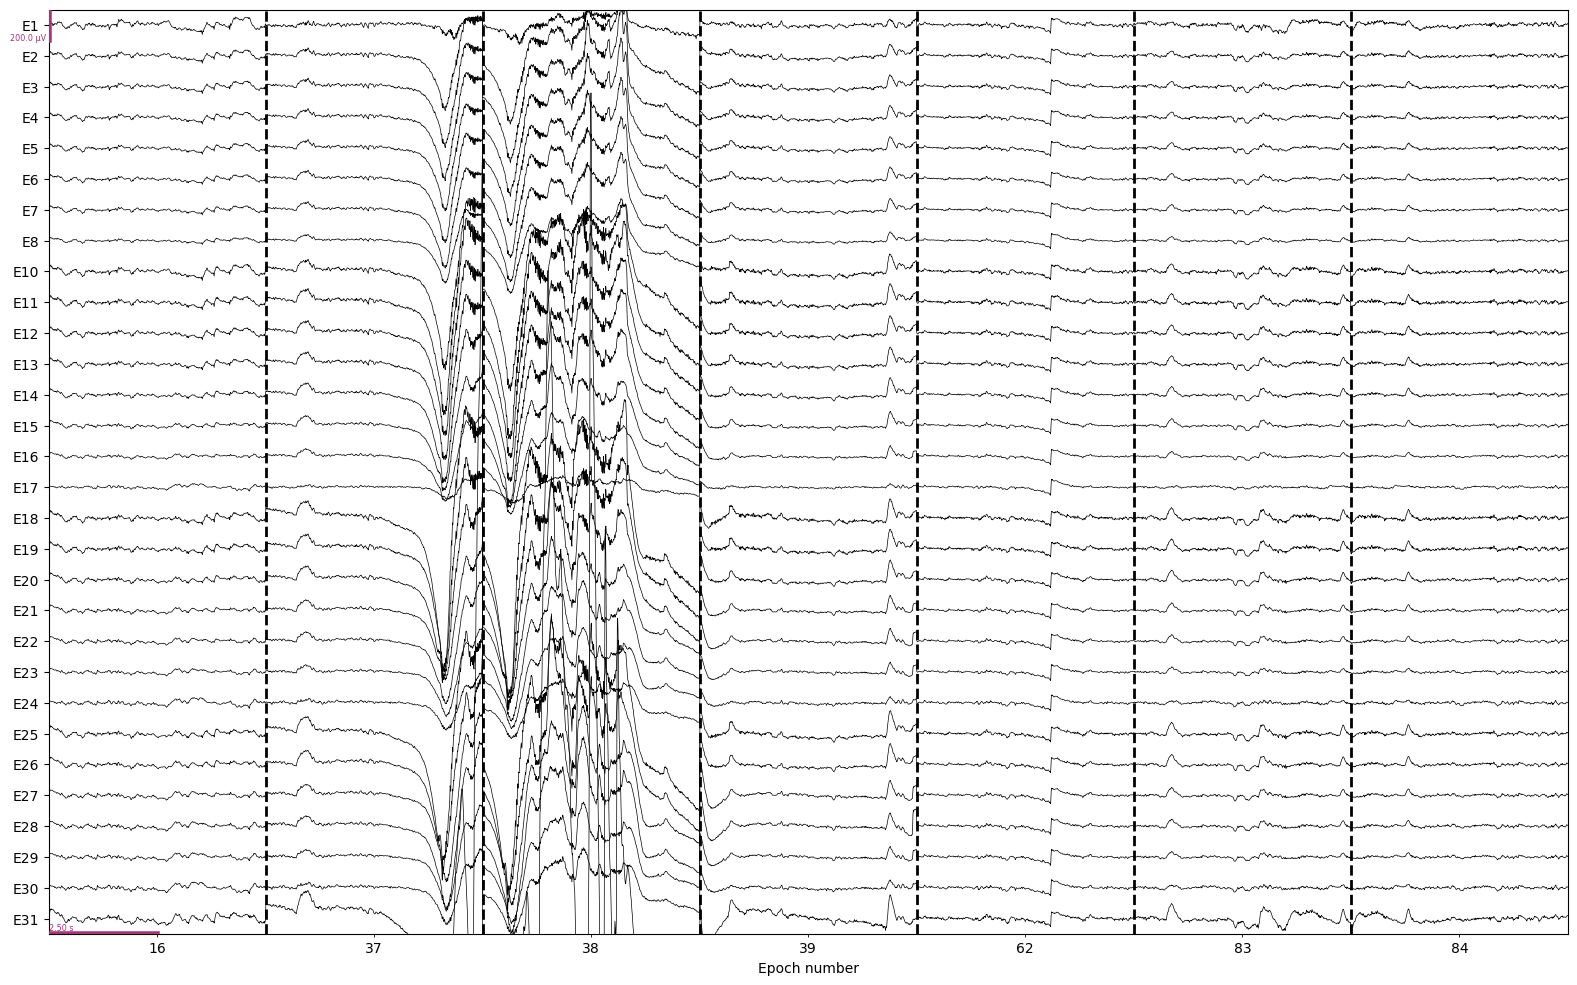

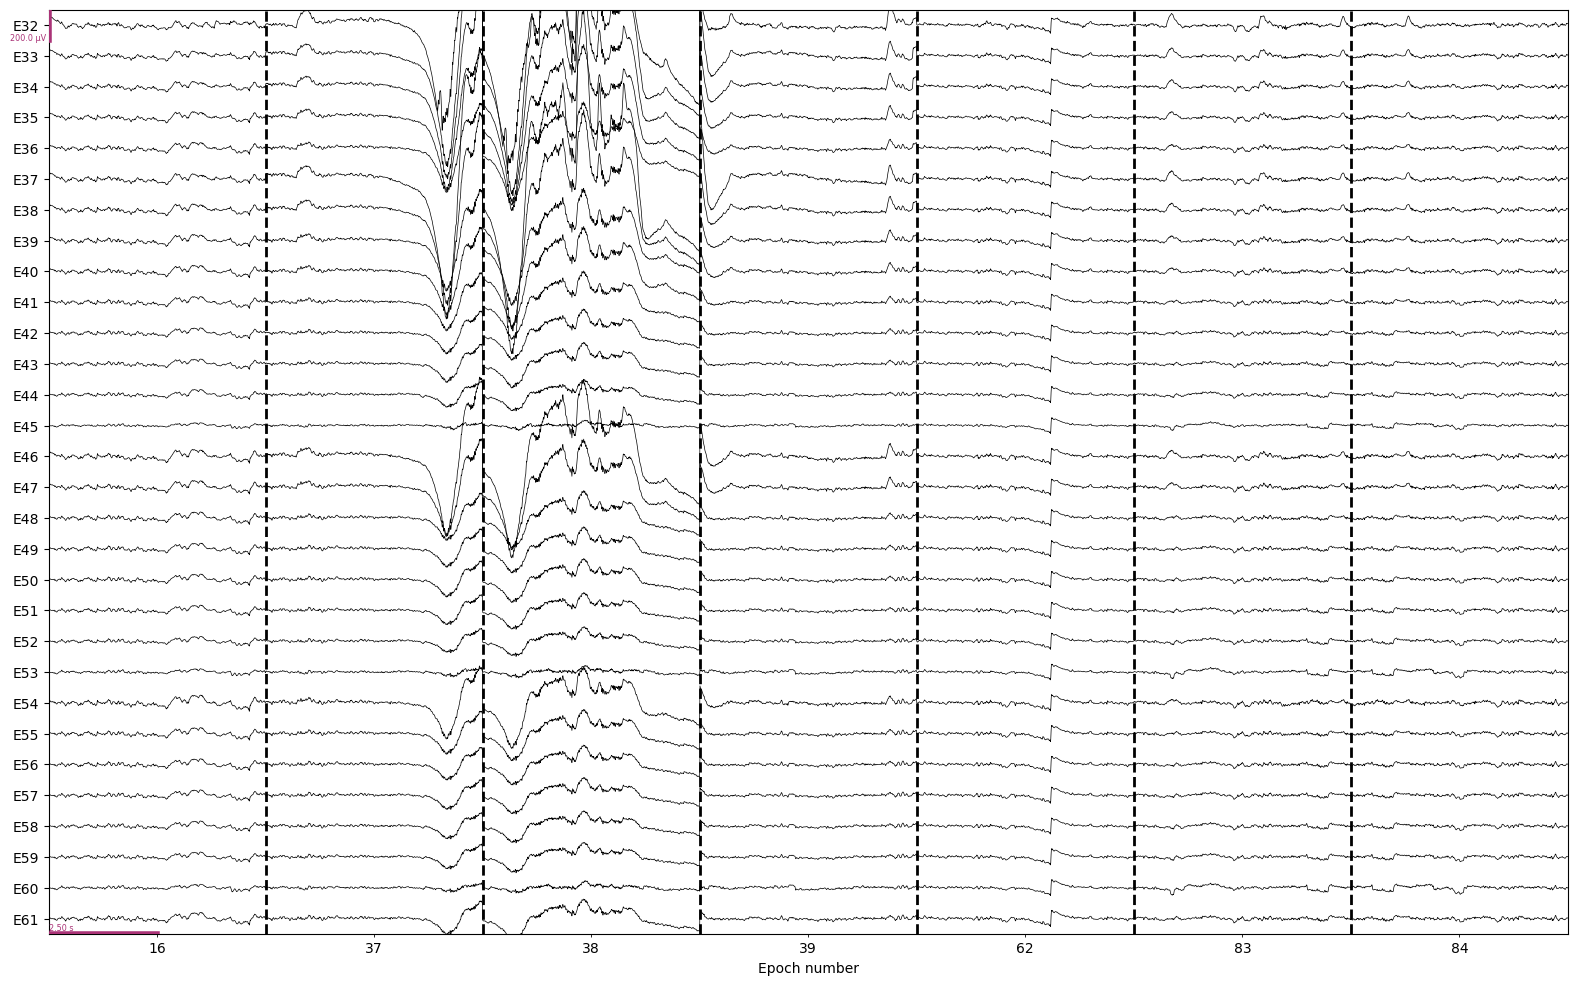

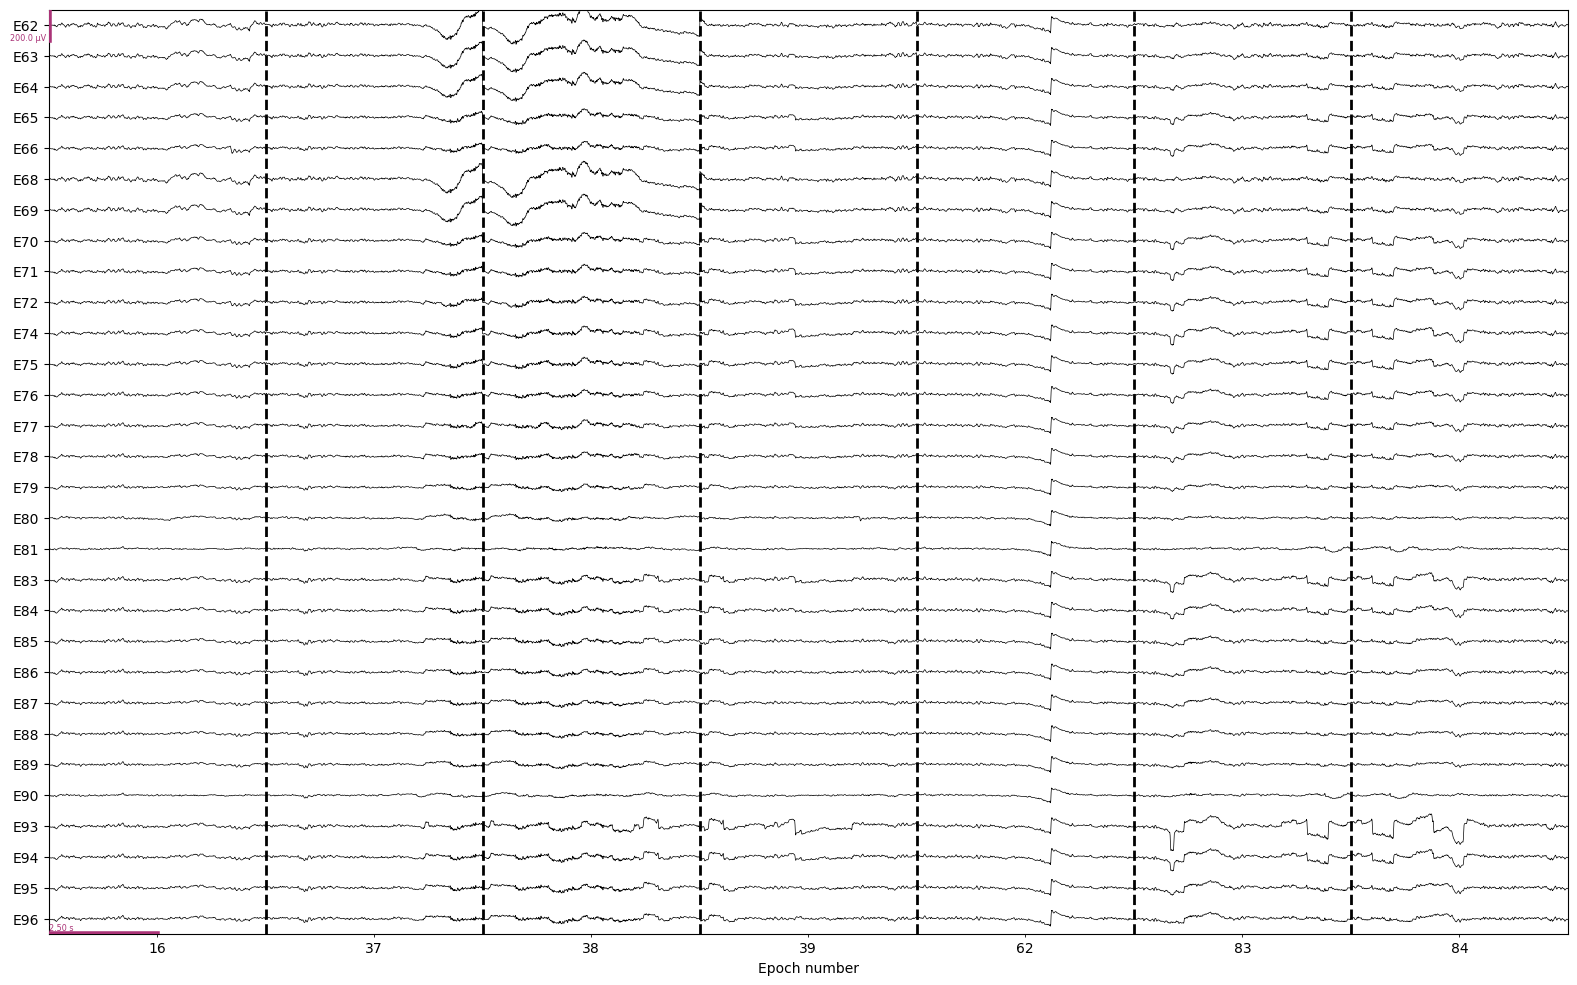

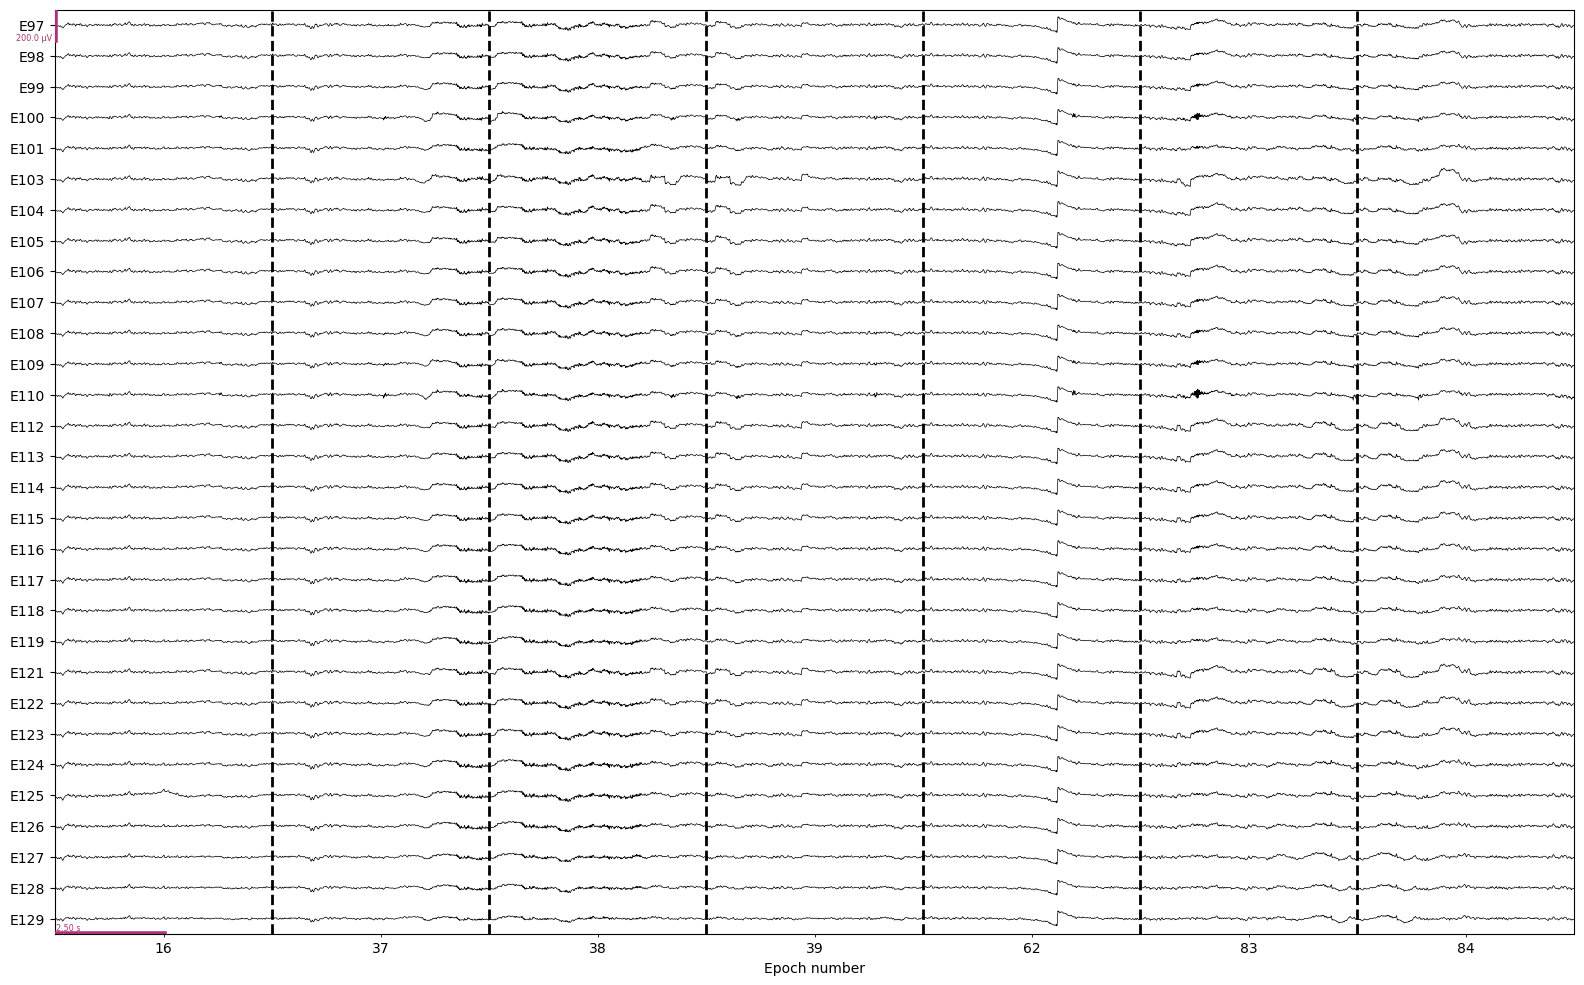

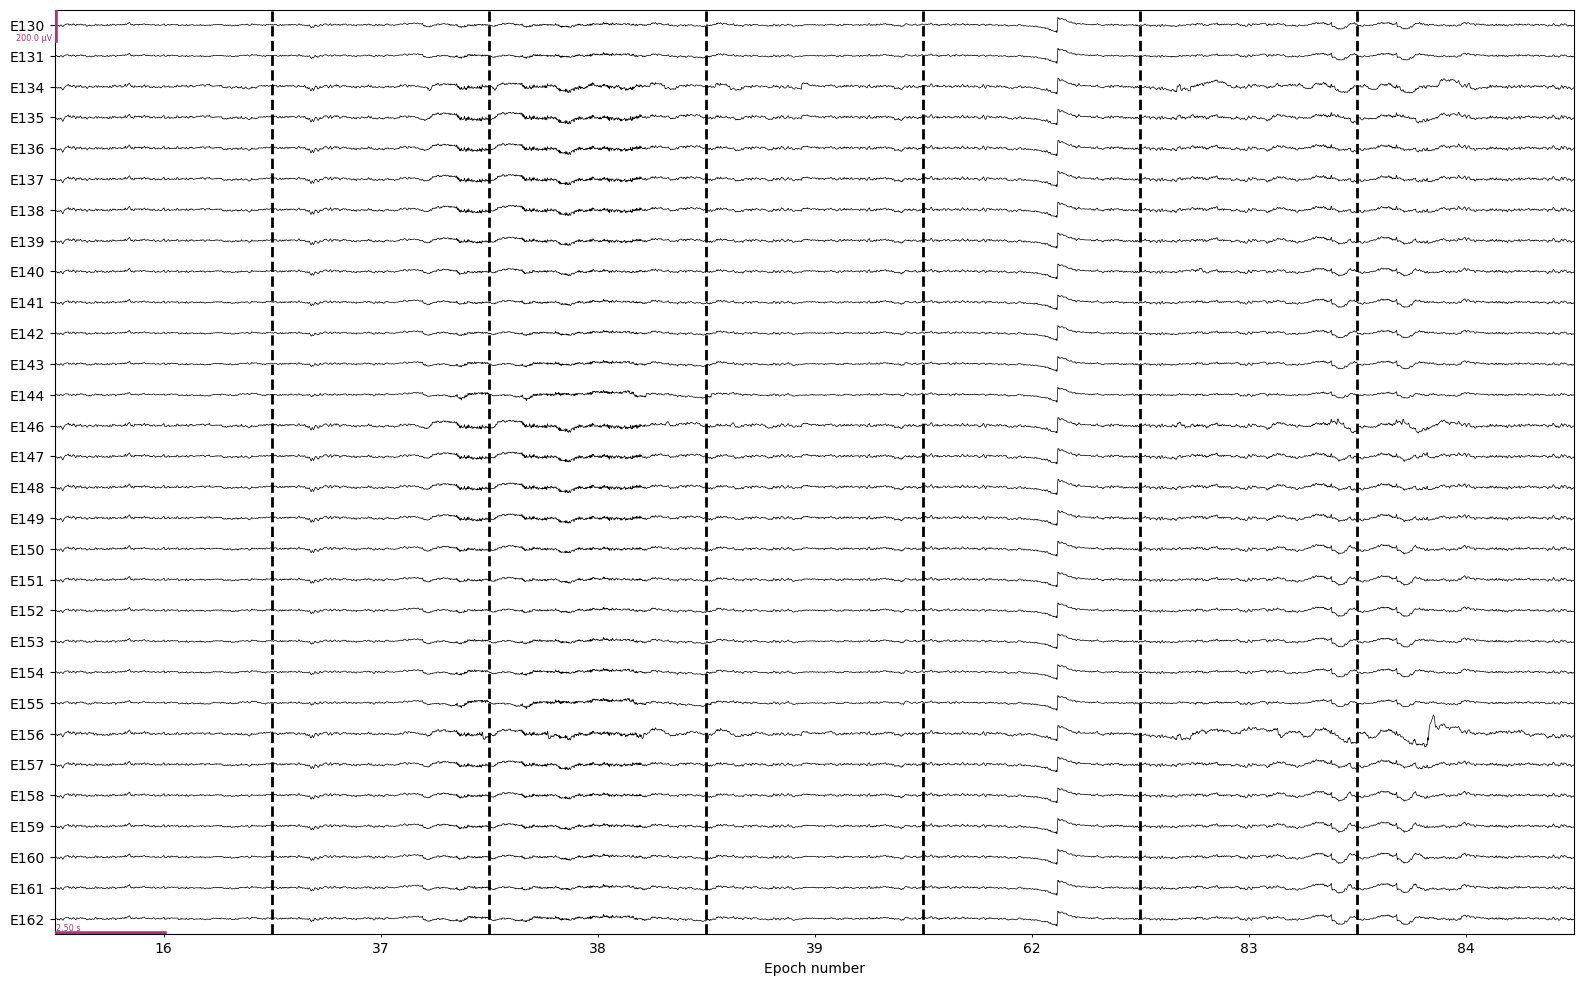

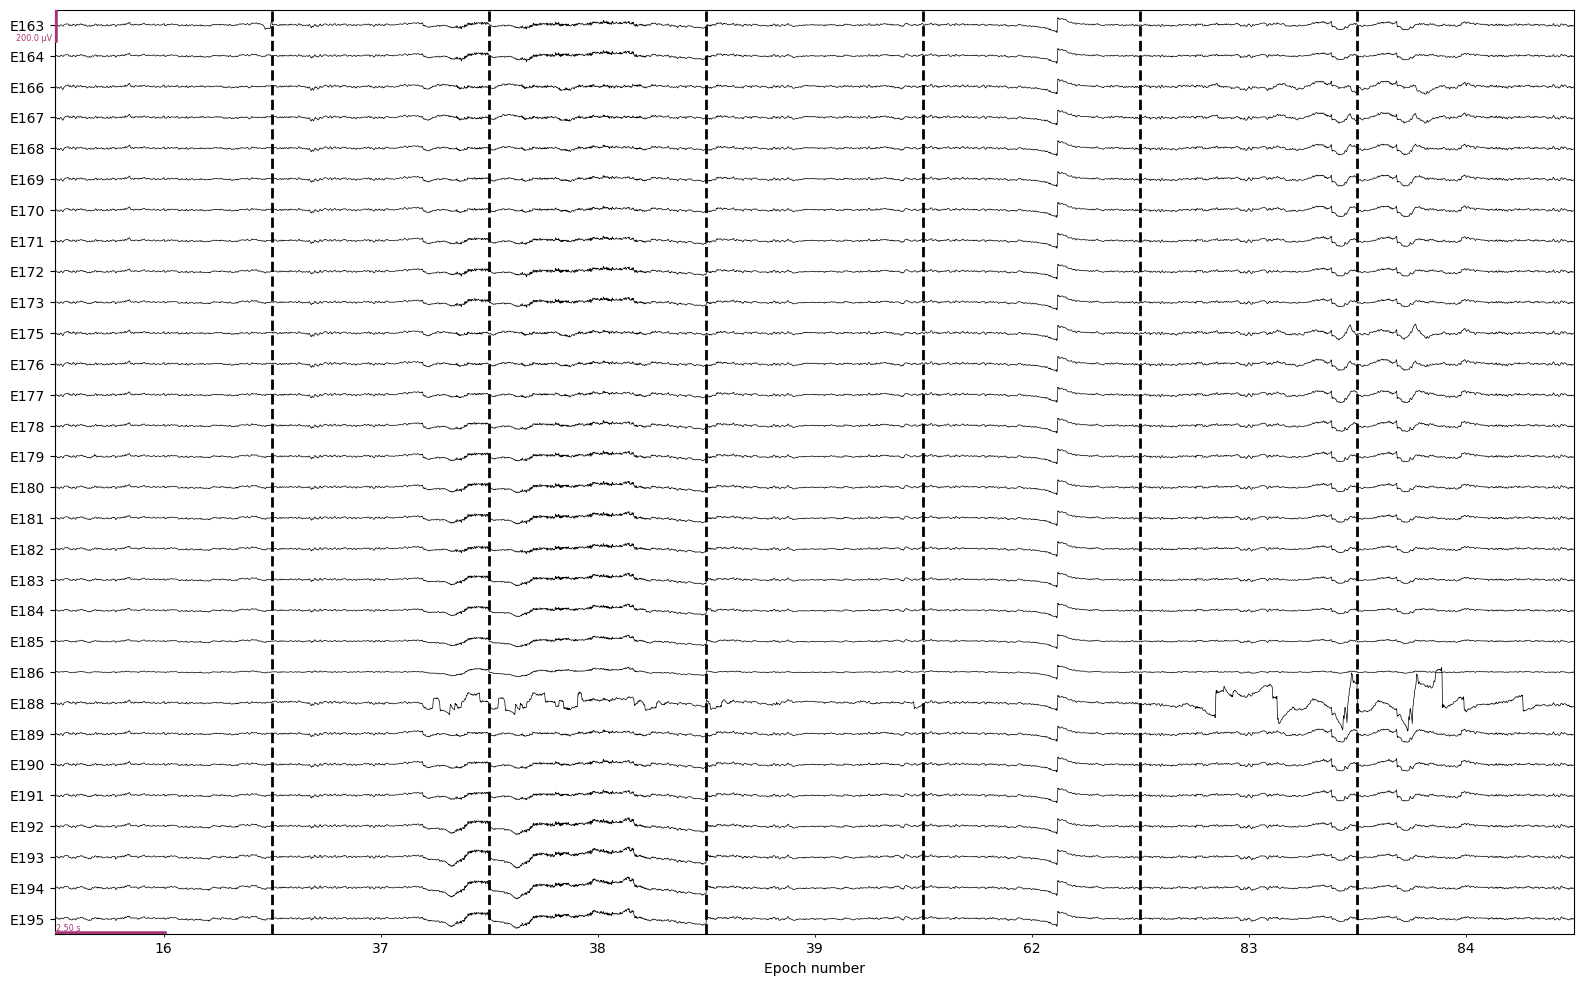

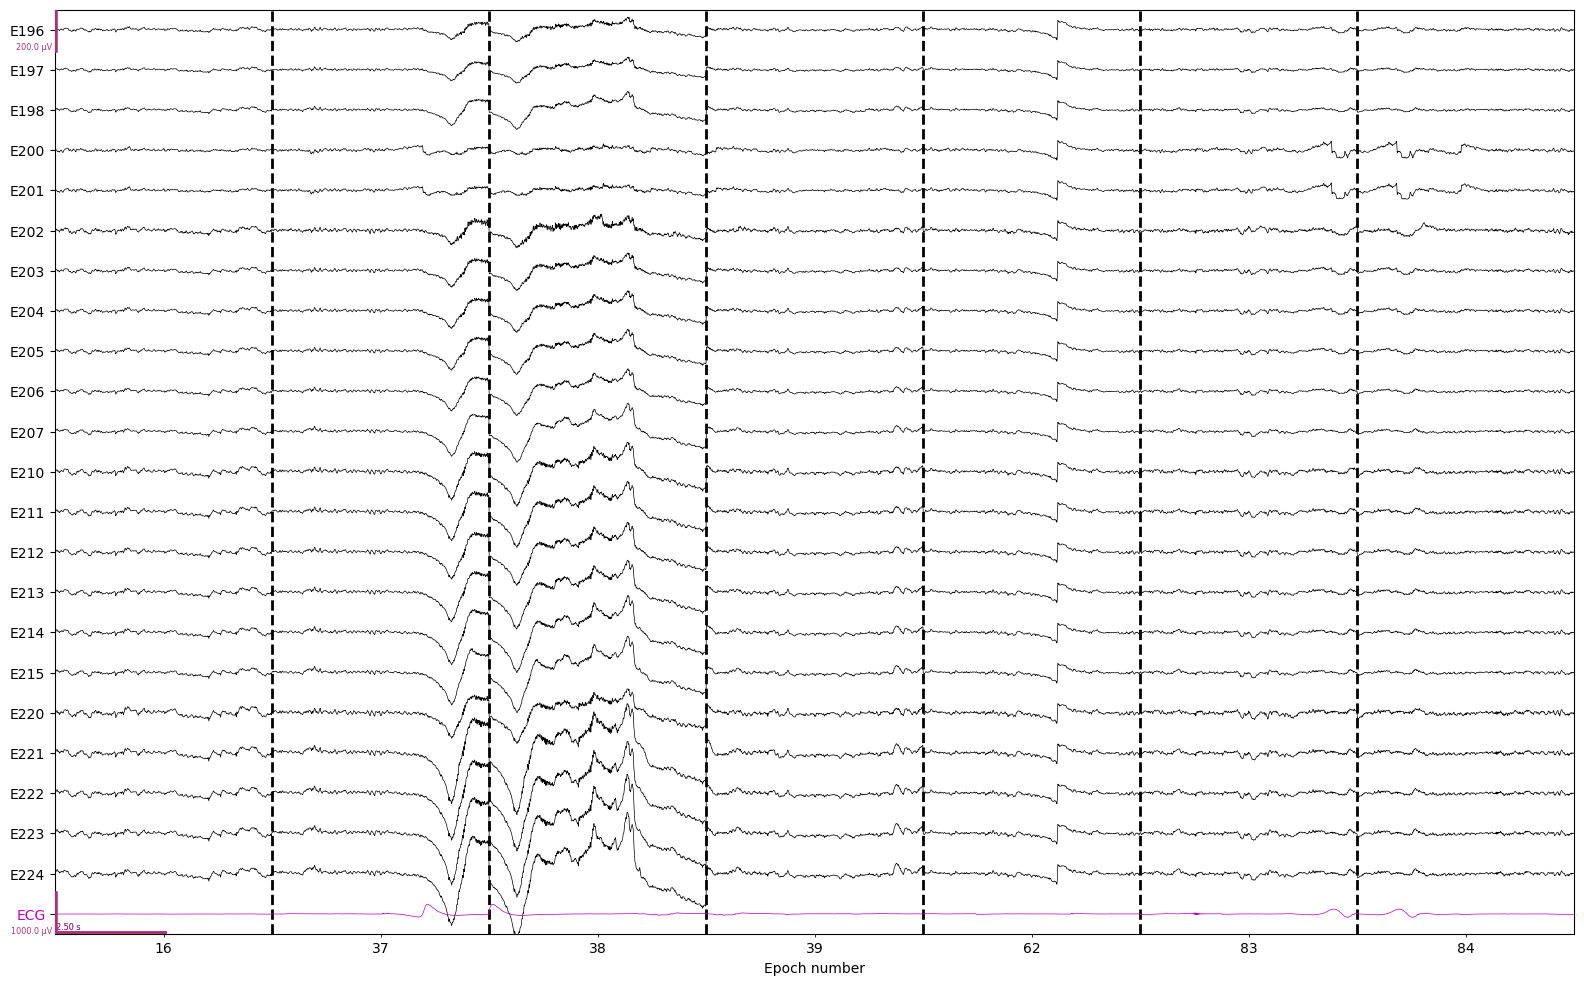

In [12]:
# Assuming 'raw' is your MNE raw object
# Get the list of all channels
all_channels = epochs.info['ch_names']

# Get the list of bad channels
bad_channels = epochs.info['bads']

# Get the list of good channels
good_channels = [ch for ch in all_channels if ch not in bad_channels]

# Get the indices of the good channels
good_channels_indices = [all_channels.index(ch) for ch in good_channels]

# Define the chunk size
chunk_size = 30

# Create chunks of the good channels
chunks = [
    good_channels_indices[i:i + chunk_size]
    for i in range(0, len(good_channels_indices), chunk_size)
]


# Now you can iterate over the chunks
for chunk in chunks:
    # Do something with the chunk
    # print(chunk)
    mne.viz.plot_epochs(
        epochs=epochs[reject_log.bad_epochs],
        picks=chunk,
        show=False,
        scalings=dict(eeg=1e-4),
        n_channels=chunk_size,
        show_scrollbars=False,
    )

In [13]:
print(f"Sub{subject} -  removed {sum(reject_log.bad_epochs)} epochs")
print(f"Sub{subject} -  retained {len(epochs[~reject_log.bad_epochs])} epochs")
print_date_time()

epochs_good = epochs[~reject_log.bad_epochs]
epochs_good.save(
    f"{project_path}/analysis/sub-{subject}_good_epochs-epo.fif", overwrite=True
)

Sub101 -  removed 7 epochs
Sub101 -  retained 78 epochs
2024-04-30 02:08:55
Overwriting existing file.
Overwriting existing file.
